In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
%matplotlib inline

In [3]:
TRAIN = True

In [4]:
path = 'c:/data/mlbootcamp/dataset/'
path_train = path + 'train/'
path_test = path + 'test/'
path_features = 'features/'
if TRAIN:
    pathfiles = path_train
    path_subs_bs_consumption = 'subs_bs_consumption_train.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_train.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_train.csv'
    path_subs_features = 'subs_features_train.csv'
    path_subs_csi = 'subs_csi_train.csv'
    path_new_features = 'features.csv'
else:
    pathfiles = path_test
    path_subs_bs_consumption = 'subs_bs_consumption_test.csv'
    path_subs_bs_data_session = 'subs_bs_data_session_test.csv'
    path_subs_bs_voice_session = 'subs_bs_voice_session_test.csv'
    path_subs_features = 'subs_features_test.csv'
    path_subs_csi = 'subs_csi_test.csv'
    path_new_features = 'features.csv'

In [5]:
from keras.callbacks import Callback
from matplotlib import pyplot as plt
from IPython.display import clear_output
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('auc'))
        self.val_acc.append(logs.get('val_auc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(15,10))
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="validation_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
subs_csi = pd.read_csv(pathfiles + path_subs_csi, sep=';', decimal=',')

In [7]:
subs_csi.head(1)

,SK_ID,CSI,CONTACT_DATE
0,2,0,04.05


In [8]:
subs_csi.shape

(4222, 3)

In [9]:
#subs_bs_consumption = pd.read_csv(pathfiles + path_subs_bs_consumption, sep=';', decimal=',')

In [10]:
#subs_bs_consumption['month'] = subs_bs_consumption['MON'].apply(lambda x:int(str(x).split('.')[1]))

In [11]:
#subs_bs_consumption.head(1)

In [12]:
#subs_bs_consumption.shape

In [13]:
#users = subs_csi['SK_ID'].unique()
#user_summary_sum_minutes = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
#user_summary_sum_data_mb = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}
#user_summary_sum_data_min = {(u, m):0 for u in users for m in subs_bs_consumption['month'].unique()}

In [14]:
#for i in subs_bs_consumption.values:
#    user_summary_sum_minutes[(i[0], i[6])] += i[3]
#    user_summary_sum_data_mb[(i[0], i[6])] += i[4]
#    user_summary_sum_data_min[(i[0], i[6])] += i[5]

In [15]:
#subs_bs_data_session = pd.read_csv(pathfiles + path_subs_bs_data_session, sep=';', decimal=',')

In [16]:
#subs_bs_data_session.head(1)

In [17]:
#subs_bs_data_session.shape

In [18]:
#subs_features = pd.read_csv(pathfiles + path_subs_features, sep=';', decimal=',')

In [19]:
#subs_features.head(1)

In [20]:
#subs_features.shape

In [21]:
#subs_features['SNAP_DATE'] = subs_features['SNAP_DATE'].apply(lambda x:datetime.strptime(x, '%d.%m.%y'))

In [22]:
#cats = subs_features['COM_CAT#24'].unique()
#subs_features['COM_CAT#242'] = pd.Categorical(subs_features['COM_CAT#24'], categories=cats)
#subs_features['COM_CAT#242'] = subs_features['COM_CAT#242'].cat.codes

In [23]:
#subs_features['COM_CAT#34'].fillna(0, inplace=True)
#subs_features['COM_CAT#8'].fillna(0, inplace=True)
#subs_features['DEVICE_TYPE_ID'].fillna(0, inplace=True)
#subs_features['ARPU_GROUP'].fillna(0, inplace=True)
#subs_features['INTERNET_TYPE_ID'].fillna(0, inplace=True)

In [24]:
#subs_features.dropna().shape

In [25]:
#subs_features['month'] = subs_features['SNAP_DATE'].apply(lambda x:x.month)
#subs_features['year'] = subs_features['SNAP_DATE'].apply(lambda x:x.year)

In [26]:
def get_subs_features(year, month, fix_month, day, sk_id):
    data = subs_features[(subs_features['year'] == year) & (subs_features['month'] == month) & (subs_features['SK_ID'] == sk_id)]
    columns = ['COM_CAT#1', 'COM_CAT#2', 'COM_CAT#3', 'BASE_TYPE', 'ACT', 'ARPU_GROUP', 'COM_CAT#7', 'COM_CAT#8',
              'DEVICE_TYPE_ID', 'INTERNET_TYPE_ID', 'REVENUE', 'ITC', 'VAS', 'RENT_CHANNEL', 'ROAM',
              'COST', 'COM_CAT#242']
    for i in range(18):
        if i + 17 == 24:
            if data.shape[0] == 1:
                d = data[['COM_CAT#24']].values[0].tolist()[0]
                dt = str(d).split('.')
                c_month = int(dt[1])
                c_day = int(dt[0])
                delta = (datetime(2002, fix_month, day) - datetime(2001 if d == '31.12' else 2002, c_month, c_day)).days
            continue
        columns.append('COM_CAT#{}'.format(i+17))
    if data.shape[0] == 1:
        return columns, data[columns].values[0].tolist()
    else:
        return columns, np.zeros(len(columns))

In [27]:
# for dnn
table = []
x = np.zeros(subs_csi.shape[0])
if TRAIN:
    y = np.zeros(subs_csi.shape[0])
for i in enumerate(subs_csi.values):
    sk_id = int(i[1][0])
    x[i[0]] = sk_id
    line = [sk_id]
    table_columns = ['sk_id']
    table.append(line)
    if TRAIN:
        y[i[0]] = i[1][1]

In [28]:
columns_avg = ['CELL_AVAILABILITY_2G', 'CELL_AVAILABILITY_3G',
       'CELL_AVAILABILITY_4G', 'CSSR_2G', 'CSSR_3G',
       'ERAB_PS_BLOCKING_RATE_LTE', 'ERAB_PS_BLOCKING_RATE_PLMN_LTE',
       'ERAB_PS_DROP_RATE_LTE', 'HSPDSCH_CODE_UTIL_3G',
       'NODEB_CNBAP_LOAD_HARDWARE', 'PART_CQI_QPSK_LTE', 'PART_MCS_QPSK_LTE',
       'PROC_LOAD_3G', 'PSSR_2G', 'PSSR_3G', 'PSSR_LTE',
       'RAB_CS_BLOCKING_RATE_3G', 'RAB_CS_DROP_RATE_3G',
       'RAB_PS_BLOCKING_RATE_3G', 'RAB_PS_DROP_RATE_3G', 'RBU_AVAIL_DL',
       'RBU_AVAIL_DL_LTE', 'RBU_AVAIL_UL', 'RBU_OTHER_DL', 'RBU_OTHER_UL',
       'RBU_OWN_DL', 'RBU_OWN_UL', 'RRC_BLOCKING_RATE_3G',
       'RRC_BLOCKING_RATE_LTE', 'RTWP_3G', 'SHO_FACTOR', 'TBF_DROP_RATE_2G',
       'TCH_DROP_RATE_2G', 'UTIL_BRD_CPU_3G', 'UTIL_CE_DL_3G',
       'UTIL_CE_HW_DL_3G', 'UTIL_CE_UL_3G', 'UTIL_SUBUNITS_3G',
       'UL_VOLUME_LTE', 'DL_VOLUME_LTE', 'TOTAL_DL_VOLUME_3G',
       'TOTAL_UL_VOLUME_3G']

In [29]:
columns_chhn = ['AVEUSERNUMBER', 'AVEUSERNUMBER_PLMN',
       'AVR_DL_HSPA_USER_3G', 'AVR_DL_R99_USER_3G', 'AVR_DL_USER_3G',
       'AVR_DL_USER_LTE', 'AVR_TX_POWER_3G', 'AVR_UL_HSPA_USER',
       'AVR_UL_R99_USER', 'AVR_UL_USER_3G', 'AVR_UL_USER_LTE',
       'DL_AVR_THROUGHPUT_3G', 'DL_AVR_THROUGHPUT_LTE',
       'DL_AVR_THROUGHPUT_R99', 'DL_MEAN_USER_THROUGHPUT_LTE',
       'DL_MEAN_USER_THROUGHPUT_DL_2G', 'DL_MEAN_USER_THROUGHPUT_HSPA3G',
       'DL_MEAN_USER_THROUGHPUT_PLTE', 'DL_MEAN_USER_THROUGHPUT_REL93G',
       'HSDPA_USERS_3G', 'HSUPA_USERS_3G', 'RBU_USED_DL', 'RBU_USED_UL',
       'RELATIVE_RBU_USED_DL', 'RELATIVE_RBU_USED_UL', 'RELATIVE_TX_POWER_3G',
       'UL_AVR_THROUGHPUT_3G', 'UL_AVR_THROUGHPUT_LTE',
       'UL_AVR_THROUGHPUT_R99', 'UL_MEAN_USER_THROUGHPUT_LTE',
       'UL_MEAN_USER_THROUGHPUT_HS3G', 'UL_MEAN_USER_THROUGHPUT_PLTE',
       'UL_MEAN_USER_THROUGHPUT_REL93G']

In [30]:
def get_columns(count, postfix):
    return ['{} {}'.format(i, postfix) for i in range(count)]       

In [31]:
def get_extend_data(type_data, column_name, count, postfix):
    fname = pathfiles + path_features + '{}_{}.csv'.format(type_data, column_name)
    result = pd.read_csv(fname)
    result.fillna(0, inplace=True)
    table = []
    result = result[get_columns(count, postfix)]
    for i in result.values:
        table.append(np.array(i).reshape((count, 1)))
    return np.array(table)

def get_all_data():
    result = None
    for columns in [columns_avg, columns_chhn]:
        for c in columns:
            for type_data in ['data', 'voice']:
                if result is None:
                    result = np.concatenate([get_extend_data(type_data, c, 63, 'sum'), get_extend_data(type_data, c, 63, 'count')], axis=2)
                for a in ['min', 'avg', 'max', 'mina', 'avga', 'maxa']:
                    t = get_extend_data(type_data, c, 63, a)
                    result = np.concatenate([result, t], axis=2)
    return result

In [32]:
data = get_extend_data('data', 'AVEUSERNUMBER', 60, 'avg')

In [33]:
data.shape

(4222, 60, 1)

In [131]:
data = get_all_data()

In [132]:
data.shape

(4222, 63, 902)

In [34]:
res_data = data

In [35]:
from sklearn import preprocessing

In [36]:
X = np.asarray(res_data)
y = np.asarray(y)

In [37]:
X = np.array(X.tolist())

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)

In [41]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [42]:
from sklearn.metrics import roc_auc_score
from keras import regularizers
from sklearn.preprocessing import normalize

In [43]:
from sklearn import metrics
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [44]:
def create_cnn_model():
    #build Keras model
    
    sequence_input = Input(shape=X_test.shape[1:], dtype='float32')
    x = Conv1D(64, 3, activation='relu')(sequence_input)
    x = MaxPooling1D(3)(x)
    x = Conv1D(64, 3, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', metrics=[auc], optimizer='adam')
    return model


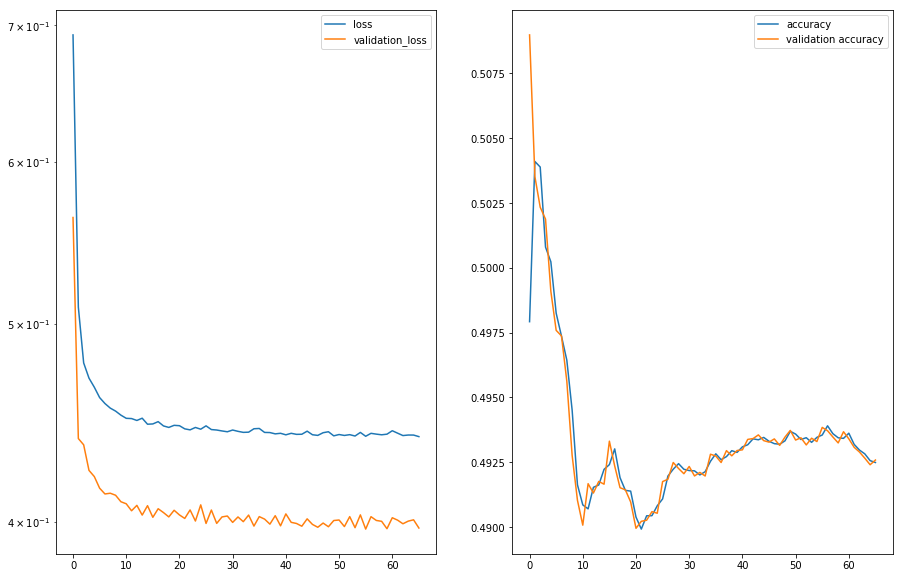

2701/2701 [==============================] - 1s 196us/step - loss: 0.4402 - auc: 0.4925 - val_loss: 0.3972 - val_auc: 0.4926


In [45]:
count_epochs = 150
model = create_cnn_model()
early_stopping_monitor = EarlyStopping(patience=10)
print(model.summary())
history = model.fit(np.array(X_train), np.array(y_train), batch_size = 128, epochs = count_epochs, verbose=1, validation_split=0.2, class_weight=class_weights, callbacks=[plot, early_stopping_monitor])

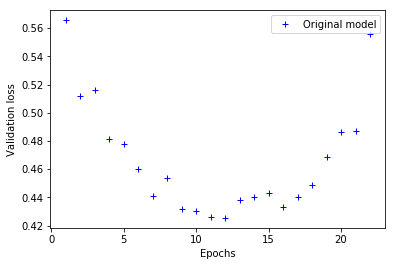

In [153]:
history_gr = history.history['val_loss']
import matplotlib.pyplot as plt
epochs = range(1, len(history_gr) + 1)
plt.plot(epochs, history_gr, 'b+', label='Original model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

In [159]:
predict = model.predict(np.array(X_test))
score = roc_auc_score(y_test, predict)
print("Total roc auc score = {0:0.4f}".format(score))

Total roc auc score = 0.5196
